In [1]:
import os
import cv2
import time
import torch
import random
import numpy as np
import albumentations as augs
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import clear_output

from utils import *
from models import *
from datasets import *
from evaluation import *


print('Ready')

Ready


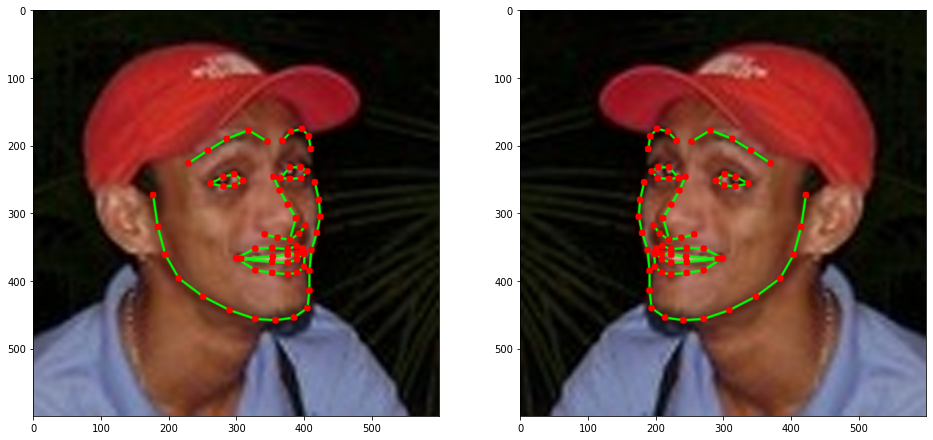

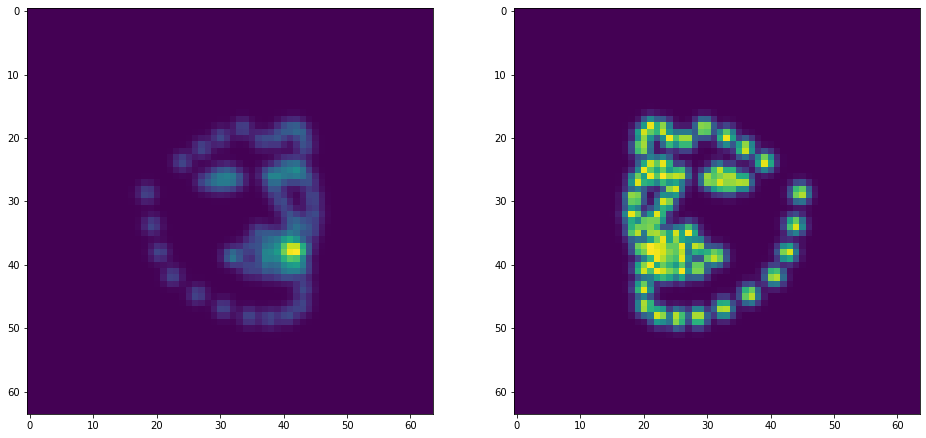

Average reconstruction error (MAE): 2.4310343801282805e-05


In [2]:
# Test pts utils
im_path = './data/300w/ibug/image_050.png'
pts_path = './data/300w/ibug/image_050.pts'
im = cv2.imread(im_path)
pts = load_pts(pts_path)
flipped_pts = flip_landmarks(pts, im.shape[1])
for idx in range(pts.shape[0]):
    clear_output(wait=True)
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    im_disp = im.copy()
    if idx > 0:
        pts_disp = pts.copy()
        pts_disp[idx:] = pts_disp[idx]
        plot_landmarks(im_disp, pts_disp, connection_thickness=2, landmark_radius=5)
    plt.imshow(im_disp[..., ::-1])
    plt.subplot(1, 2, 2)
    im_disp = im[:, ::-1, :].copy()
    if idx > 0:
        pts_disp = flipped_pts.copy()
        pts_disp[idx:] = pts_disp[idx]
        plot_landmarks(im_disp, pts_disp, connection_thickness=2, landmark_radius=5)
    plt.imshow(im_disp[..., ::-1])
    plt.show()
    time.sleep(0.1)

heatmaps = encode_landmarks(pts / im.shape[1::-1] * 64, 64, 64, 5, 1)
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(heatmaps.sum(axis=0))
heatmaps = encode_landmarks(flipped_pts / im.shape[1::-1] * 64, 64, 64, 5, 1)
plt.subplot(1, 2, 2)
plt.imshow(heatmaps.max(axis=0)[0])
plt.show()
recon_err = np.abs(flipped_pts - decode_landmarks(heatmaps)[0].detach().cpu().numpy() / 64 * im.shape[1::-1]).mean()
print(f"Average reconstruction error (MAE): {recon_err}")

In [3]:
# Test the dataset class
ibug_300w_lp_train = LandmarkDataset('data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                                     random_flip=True)
ibug_300w_lp_train.geometric_transform = augs.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT)
ibug_300w_lp_train.content_transform = augs.Compose([augs.Blur(p=0.5), augs.ColorJitter(p=0.5),
                                                     augs.ImageCompression(quality_lower=30, p=0.5)])
print(f"{len(ibug_300w_lp_train)} samples located.")

180689 samples located.


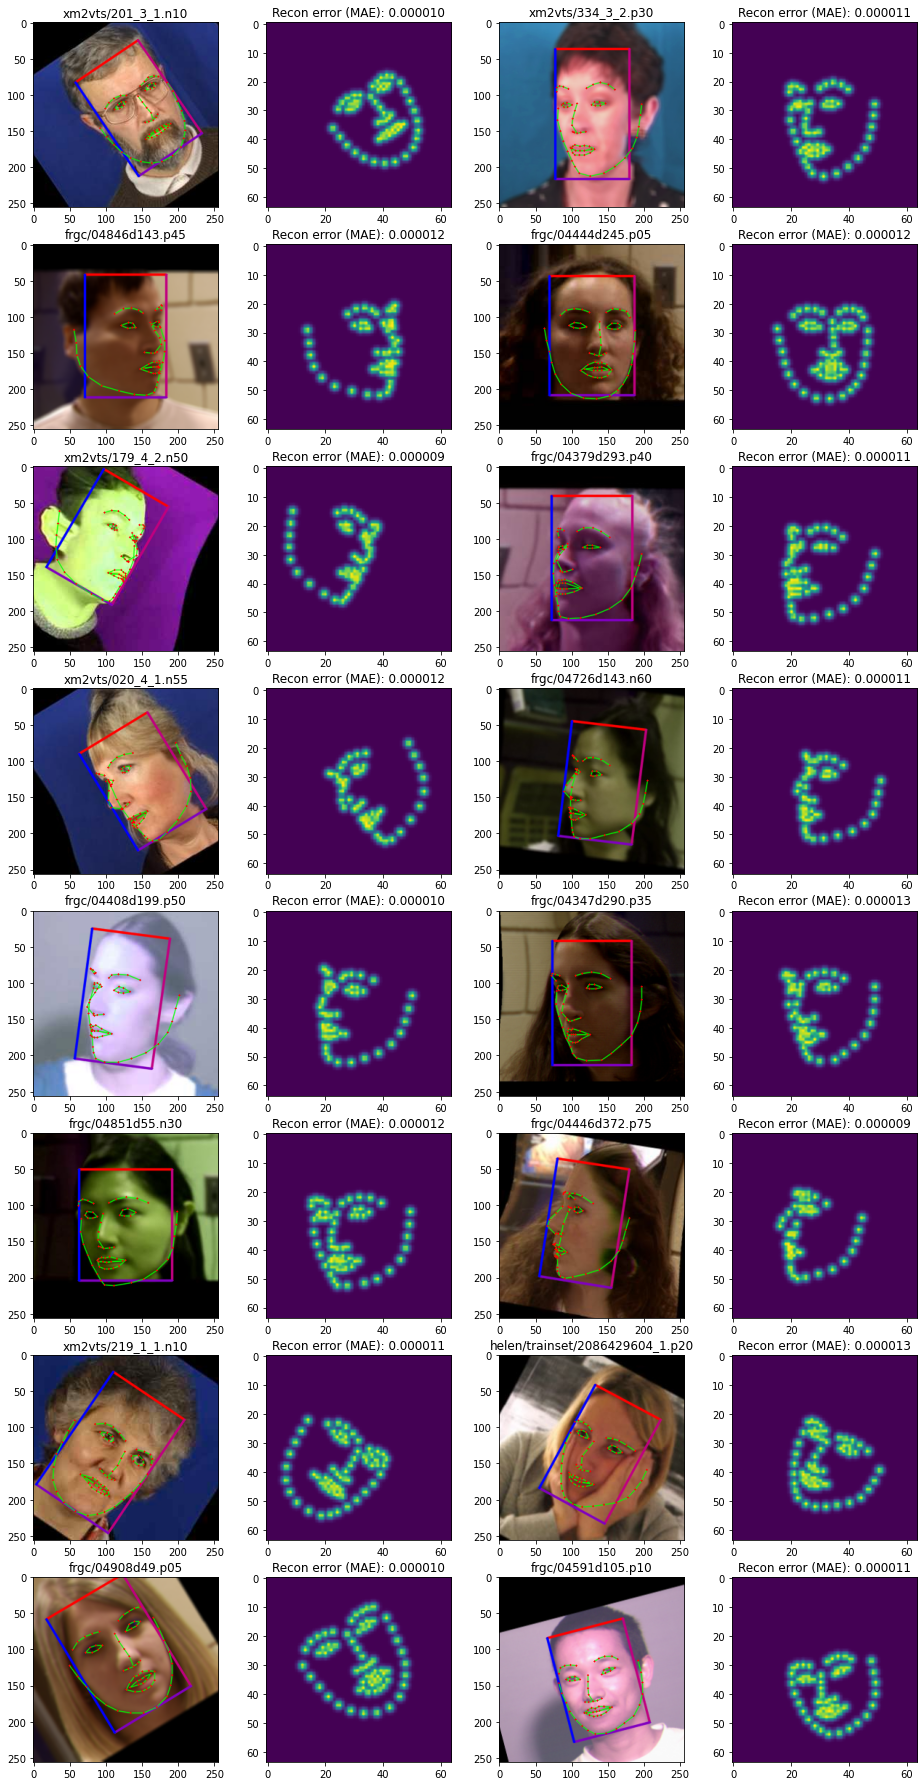

In [4]:
# Show some examples from the dataset
fig = plt.figure(figsize=(16, 32))
for idx in range(16):
    plt.subplot(8, 4, idx * 2 + 1)
    im, ht, pts, fcs, metadata = ibug_300w_lp_train[random.randint(0, len(ibug_300w_lp_train) - 1)]
    pts, fcs = pts.detach().cpu().numpy(), fcs.detach().cpu().numpy()
    im = (im.numpy().transpose((1, 2, 0)) * 255.0).astype(np.uint8)
    cv2.line(im, tuple(fcs[0].astype(int).tolist()), tuple(fcs[1].astype(int).tolist()),
             color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
    cv2.line(im, tuple(fcs[1].astype(int).tolist()), tuple(fcs[2].astype(int).tolist()),
             color=(192, 0, 128), thickness=2, lineType=cv2.LINE_AA)
    cv2.line(im, tuple(fcs[2].astype(int).tolist()), tuple(fcs[3].astype(int).tolist()),
             color=(128, 0, 192), thickness=2, lineType=cv2.LINE_AA)
    cv2.line(im, tuple(fcs[3].astype(int).tolist()), tuple(fcs[0].astype(int).tolist()),
             color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
    plot_landmarks(im, pts, landmark_colour=(255, 0, 0))
    plt.imshow(im)
    plt.title(os.path.join(metadata['subset'], metadata['split'],
                           os.path.splitext(os.path.basename(metadata['im_path']))[0]))
    plt.subplot(8, 4, idx * 2 + 2)
    plt.imshow(ht.max(axis=0)[0])
    recon_err = np.abs(pts - decode_landmarks(ht)[0].detach().cpu().numpy() / 64 * im.shape[1::-1]).mean()
    plt.title(f"Recon error (MAE): {recon_err:.06f}")
plt.show()

Data loader created.
Pretrained model loaded.


  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

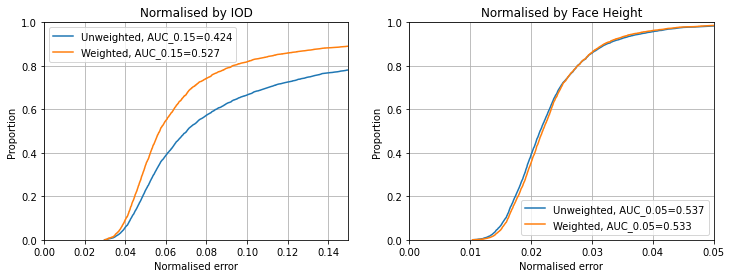

In [11]:
# Test the evaluation function
ibug_300w_lp_test = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'test'))
test_loader = DataLoader(ibug_300w_lp_test, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loader created.')

fan = FAN(FAN.create_config(num_modules=4, use_avg_pool=True)).cuda()
fan.load_state_dict(torch.load('./pretrained/2dfan4.pth'))
print('Pretrained model loaded.')

th_iod = 0.15
th_fh = 0.05
with torch.no_grad():
    auc1, errs1, ticks1 = evaluate_model(fan, test_loader, th_iod,
                                         pbar=tqdm(total=len(test_loader)))
    auc2, errs2, ticks2 = evaluate_model(fan, test_loader, th_iod, use_sample_weight=True,
                                         pbar=tqdm(total=len(test_loader)))
    auc3, errs3, ticks3 = evaluate_model(fan, test_loader, th_fh, norm_by_face_height=True,
                                         pbar=tqdm(total=len(test_loader)))
    auc4, errs4, ticks4 = evaluate_model(fan, test_loader, th_fh, norm_by_face_height=True, use_sample_weight=True,
                                         pbar=tqdm(total=len(test_loader)))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(errs1, ticks1, label=f"Unweighted, AUC_{th_iod}={auc1:.03f}")
plt.plot(errs2, ticks2, label=f"Weighted, AUC_{th_iod}={auc2:.03f}")
plt.title('Normalised by IOD')
plt.xlim(0, th_iod)
plt.ylim(0, 1)
plt.xlabel('Normalised error')
plt.ylabel('Proportion')
plt.legend()
plt.grid('both')
plt.subplot(1, 2, 2)
plt.plot(errs3, ticks3, label=f"Unweighted, AUC_{th_fh}={auc3:.03f}")
plt.plot(errs4, ticks4, label=f"Weighted, AUC_{th_fh}={auc4:.03f}")
plt.title('Normalised by Face Height')
plt.xlim(0, th_fh)
plt.ylim(0, 1)
plt.xlabel('Normalised error')
plt.ylabel('Proportion')
plt.legend()
plt.grid('both')